<a href="https://www.kaggle.com/code/darrellcr/efficientnetv2-plantvillage-proportion-search?scriptVersionId=185704499" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import glob

from keras.src.applications.efficientnet_v2 import EfficientNetV2
import tensorflow as tf
import random
import cv2
import skimage

import matplotlib.pyplot as plt
import numpy as np

2024-06-27 07:07:04.213089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 07:07:04.213219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 07:07:04.343322: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# L 100%

In [3]:
class PlantVillageGenerator:
    def __init__(self, files_path, labels_to_idx, image_size, shuffle=True, color_space='rgb', split_channel=None):
        self.files_path = files_path
        self.labels_to_idx = labels_to_idx
        self.image_size = image_size
        self.shuffle = shuffle
        self.color_space = color_space
        self.split_channel = split_channel
    
    def __call__(self):
        if self.shuffle:
            random.shuffle(self.files_path)
        
        for file_path in self.files_path:
            label_str = Path(file_path).parent.name
            label_idx = self.labels_to_idx[label_str]
            label_oh = tf.one_hot(label_idx, len(self.labels_to_idx))

            image = tf.keras.preprocessing.image.load_img(file_path)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            image_arr = tf.image.resize(image_arr, self.image_size)
            image_arr /= 255.

            if self.color_space == 'lab':
                image_arr = tf.py_function(func=skimage.color.rgb2lab, inp=[image_arr], Tout=tf.float32)
                image_arr = (image_arr + [0, 128, 128]) / [100, 255, 255]
                image_arr.set_shape((*self.image_size, 3))
            elif self.color_space != 'rgb':
                raise NotImplementedError

            if self.split_channel:
                first_channel = tf.reshape(image_arr[:, :, 0], (*self.image_size, 1))
                second_channel = tf.reshape(image_arr[:, :, 1], (*self.image_size, 1))
                third_channel = tf.reshape(image_arr[:, :, 2], (*self.image_size, 1))
                
                concat = tf.concat([second_channel, third_channel], 2)

                yield first_channel, label_oh
            else:
                yield image_arr, label_oh

In [4]:
from collections import defaultdict
import copy
import random
from pathlib import Path

def train_validation_test_split(files_path, train_size=0.7, validation_size=0.2):
    files_path = copy.deepcopy(files_path)
    random.shuffle(files_path)
    
    files_per_class = defaultdict(list)
    for f in files_path:
        label = Path(f).parent.name
        files_per_class[label].append(f)
    
    split_files = defaultdict(list)
    for c, files in files_per_class.items():
        train_count = int(len(files) * train_size)
        validation_count = int(len(files) * validation_size)
        
        split_files['train'] += (files[:train_count])
        split_files['validation'] += (files[train_count:(train_count+validation_count)])
        split_files['test'] += (files[(train_count+validation_count):])
    
    return split_files

In [5]:
files_path = glob.glob('/kaggle/input/plantvillage-dataset/color/**/**')
split_files = train_validation_test_split(files_path)
classes = set([Path(f).parent.name for f in files_path])
labels_to_idx = {c: i for i, c in enumerate(classes)}

output_signature = (tf.TensorSpec(shape = (None, None, 1), dtype = tf.float32),
                    tf.TensorSpec(shape = len(labels_to_idx), dtype = tf.int16))

train = tf.data.Dataset.from_generator(
    PlantVillageGenerator(split_files['train'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)
validation = tf.data.Dataset.from_generator(
    PlantVillageGenerator(split_files['validation'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)
test = tf.data.Dataset.from_generator(
    PlantVillageGenerator(split_files['test'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation = validation.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [7]:
batched_train = train.batch(32)
batched_validation = validation.batch(32)
batched_test = test.batch(32)

In [9]:
model = EfficientNetV2(
    width_coefficient=0.5,
    depth_coefficient=0.5,
    default_size=128,
    dropout_rate=0.5,
    model_name='efficientnetv2-b0',
    weights=None,
    input_shape=(128, 128, 1),
    classes=38
)

model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        144 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │         64 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64, 8) │      1,152 │ stem_activation[… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64, 8) │         32 │ block1a_project_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64, 8) │          0 │ block1a_project_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        128 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │        512 │ block2a_expand_a… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │         64 │ block2a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_expand_conv │ (None, 16, 16,    │      9,216 │ block2a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_expand_bn   │ (None, 16, 16,    │        256 │ block3a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_expand_act… │ (None, 16, 16,    │          0 │ block3a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_project_co… │ (None, 16, 16,    │      1,536 │ block3a_expand_a

 Total params: 803,462 (3.06 MB)

 Trainable params: 787,318 (3.00 MB)

 Non-trainable params: 16,144 (63.06 KB)

In [10]:
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

checkpoint_path = "/kaggle/working/two_branch_efficientnetv2scustom_L100/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
      1/Unknown 69s 69s/step - accuracy: 0.0312 - loss: 4.0101

W0000 00:00:1719472407.885604     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   1188/Unknown 655s 494ms/step - accuracy: 0.2900 - loss: 2.6377

W0000 00:00:1719472993.726357     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719473015.429939     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.03291, saving model to /kaggle/working/two_branch_efficientnetv2scustom_L100/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 829s 640ms/step - accuracy: 0.2901 - loss: 2.6372 - val_accuracy: 0.0329 - val_loss: 8.0596
Epoch 2/25
1186/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5958 - loss: 1.3381
Epoch 2: val_accuracy did not improve from 0.03291
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.5959 - loss: 1.3378 - val_accuracy: 0.0247 - val_loss: 11.5804
Epoch 3/25
1185/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6871 - loss: 1.0176
Epoch 3: val_accuracy did not improve from 0.03291
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.6872 - loss: 1.0174 - val_accuracy: 0.0214 - val_loss: 28.0908
Epoch 4/25
1186/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7350 - loss: 0.8484
Epoch 4: val_accuracy improved from 0.03291 to 0.04950, saving model to /kaggle/working/two_branch_efficientnetv2scustom_L100/

In [11]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2scustom_L100/cp-0017.keras')
saved.evaluate(batched_test, verbose=2)

W0000 00:00:1719473726.899012     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 - 7s - 42ms/step - accuracy: 0.8657 - loss: 0.4844


[0.48442021012306213, 0.8657263517379761]

In [12]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) # How many epochs


    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

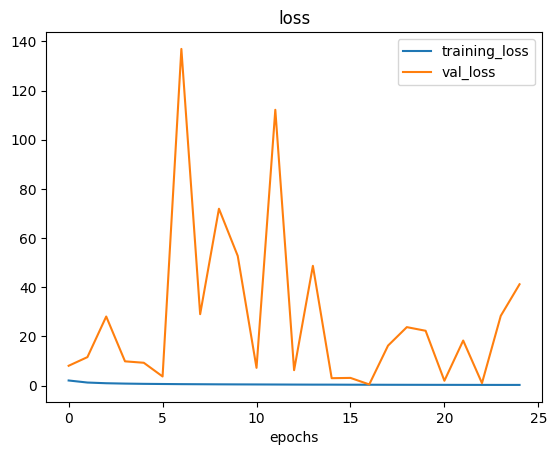

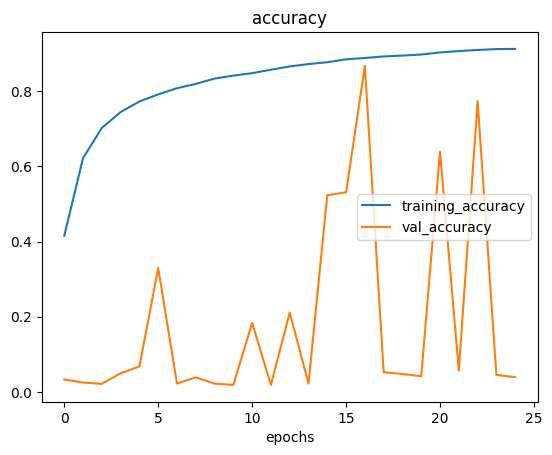

In [13]:
plot_loss_curves(history)

# L 0%

In [14]:
class PlantVillageGeneratorL0:
    def __init__(self, files_path, labels_to_idx, image_size, shuffle=True, color_space='rgb', split_channel=None):
        self.files_path = files_path
        self.labels_to_idx = labels_to_idx
        self.image_size = image_size
        self.shuffle = shuffle
        self.color_space = color_space
        self.split_channel = split_channel
    
    def __call__(self):
        if self.shuffle:
            random.shuffle(self.files_path)
        
        for file_path in self.files_path:
            label_str = Path(file_path).parent.name
            label_idx = self.labels_to_idx[label_str]
            label_oh = tf.one_hot(label_idx, len(self.labels_to_idx))

            image = tf.keras.preprocessing.image.load_img(file_path)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            image_arr = tf.image.resize(image_arr, self.image_size)
            image_arr /= 255.

            if self.color_space == 'lab':
                image_arr = tf.py_function(func=skimage.color.rgb2lab, inp=[image_arr], Tout=tf.float32)
                image_arr = (image_arr + [0, 128, 128]) / [100, 255, 255]
                image_arr.set_shape((*self.image_size, 3))
            elif self.color_space != 'rgb':
                raise NotImplementedError

            if self.split_channel:
                first_channel = tf.reshape(image_arr[:, :, 0], (*self.image_size, 1))
                second_channel = tf.reshape(image_arr[:, :, 1], (*self.image_size, 1))
                third_channel = tf.reshape(image_arr[:, :, 2], (*self.image_size, 1))
                
                concat = tf.concat([second_channel, third_channel], 2)

                yield concat, label_oh
            else:
                yield image_arr, label_oh

In [15]:
files_path = glob.glob('/kaggle/input/plantvillage-dataset/color/**/**')
split_files = train_validation_test_split(files_path)
classes = set([Path(f).parent.name for f in files_path])
labels_to_idx = {c: i for i, c in enumerate(classes)}

output_signature = (tf.TensorSpec(shape = (None, None, 2), dtype = tf.float32),
                    tf.TensorSpec(shape = len(labels_to_idx), dtype = tf.int16))

train = tf.data.Dataset.from_generator(
    PlantVillageGeneratorL0(split_files['train'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)
validation = tf.data.Dataset.from_generator(
    PlantVillageGeneratorL0(split_files['validation'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)
test = tf.data.Dataset.from_generator(
    PlantVillageGeneratorL0(split_files['test'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation = validation.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

batched_train = train.batch(32)
batched_validation = validation.batch(32)
batched_test = test.batch(32)

In [17]:
modell0 = EfficientNetV2(
    width_coefficient=0.5,
    depth_coefficient=0.5,
    default_size=128,
    dropout_rate=0.5,
    model_name='efficientnetv2-b0',
    weights=None,
    input_shape=(128, 128, 2),
    classes=38
)

modell0.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/applications/efficientnet_v2.py:909: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        288 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │         64 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64, 8) │      1,152 │ stem_activation[… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64, 8) │         32 │ block1a_project_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64, 8) │          0 │ block1a_project_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        128 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │        512 │ block2a_expand_a… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │         64 │ block2a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_expand_conv │ (None, 16, 16,    │      9,216 │ block2a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_expand_bn   │ (None, 16, 16,    │        256 │ block3a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_expand_act… │ (None, 16, 16,    │          0 │ block3a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_project_co… │ (None, 16, 16,    │      1,536 │ block3a_expand_a

 Total params: 803,606 (3.07 MB)

 Trainable params: 787,462 (3.00 MB)

 Non-trainable params: 16,144 (63.06 KB)

In [18]:
modell0.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

checkpoint_path = "/kaggle/working/two_branch_efficientnetv2custom_L0/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

history = modell0.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
      1/Unknown 60s 60s/step - accuracy: 0.0625 - loss: 3.9775

W0000 00:00:1719473844.980779     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   1188/Unknown 448s 327ms/step - accuracy: 0.2661 - loss: 2.7312

W0000 00:00:1719474233.074138     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719474246.523145     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.01180, saving model to /kaggle/working/two_branch_efficientnetv2custom_L0/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 555s 418ms/step - accuracy: 0.2662 - loss: 2.7306 - val_accuracy: 0.0118 - val_loss: 10.4206
Epoch 2/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5836 - loss: 1.3746
Epoch 2: val_accuracy improved from 0.01180 to 0.02055, saving model to /kaggle/working/two_branch_efficientnetv2custom_L0/cp-0002.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5837 - loss: 1.3745 - val_accuracy: 0.0206 - val_loss: 156.9127
Epoch 3/25
1186/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6475 - loss: 1.1183
Epoch 3: val_accuracy improved from 0.02055 to 0.09872, saving model to /kaggle/working/two_branch_efficientnetv2custom_L0/cp-0003.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.6476 - loss: 1.1182 - val_accuracy: 0.0987 - val_loss: 30.8176
Epoch 4/25
1186/1188 ━━━━━━━━━━━━━━━━━━━━ 0s

In [19]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2custom_L0/cp-0017.keras')
saved.evaluate(batched_test, verbose=2)

W0000 00:00:1719475523.311175     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 - 63s - 371ms/step - accuracy: 0.4142 - loss: 4.1986


[4.198583126068115, 0.41417843103408813]

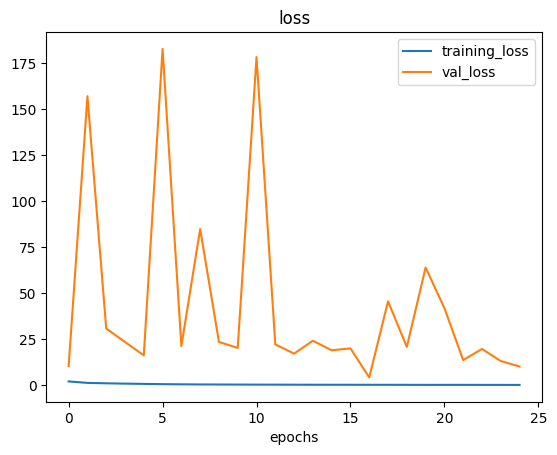

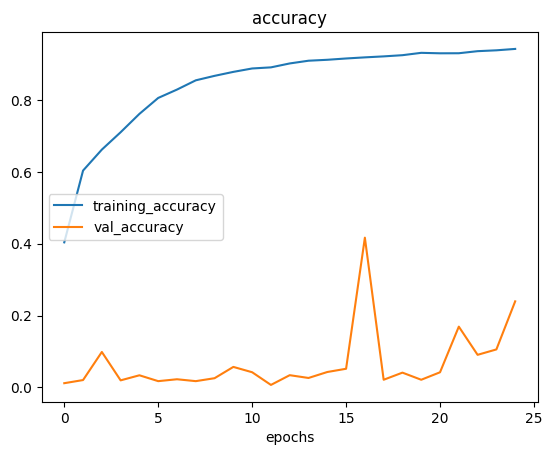

In [20]:
plot_loss_curves(history)

# L20%

In [1]:
import glob
from pathlib import Path

import tensorflow as tf
import random
import cv2
import skimage

import matplotlib.pyplot as plt
import numpy as np

2024-06-27 05:28:16.641435: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 05:28:16.641540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 05:28:16.802359: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class PlantVillageGenerator:
    def __init__(self, files_path, labels_to_idx, image_size, shuffle=True, color_space='rgb', split_channel=None):
        self.files_path = files_path
        self.labels_to_idx = labels_to_idx
        self.image_size = image_size
        self.shuffle = shuffle
        self.color_space = color_space
        self.split_channel = split_channel
    
    def __call__(self):
        if self.shuffle:
            random.shuffle(self.files_path)
        
        for file_path in self.files_path:
            label_str = Path(file_path).parent.name
            label_idx = self.labels_to_idx[label_str]
            label_oh = tf.one_hot(label_idx, len(self.labels_to_idx))

            image = tf.keras.preprocessing.image.load_img(file_path)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            image_arr = tf.image.resize(image_arr, self.image_size)
            image_arr /= 255.

            if self.color_space == 'lab':
                image_arr = tf.py_function(func=skimage.color.rgb2lab, inp=[image_arr], Tout=tf.float32)
                image_arr = (image_arr + [0, 128, 128]) / [100, 255, 255]
                image_arr.set_shape((*self.image_size, 3))
            elif self.color_space != 'rgb':
                raise NotImplementedError

            if self.split_channel:
                first_channel = tf.reshape(image_arr[:, :, 0], (*self.image_size, 1))
                second_channel = tf.reshape(image_arr[:, :, 1], (*self.image_size, 1))
                third_channel = tf.reshape(image_arr[:, :, 2], (*self.image_size, 1))
                
                concat = tf.concat([second_channel, third_channel], 2)

                yield (first_channel, concat), label_oh
            else:
                yield image_arr, label_oh

In [3]:
from collections import defaultdict
import copy
import random
from pathlib import Path

def train_validation_test_split(files_path, train_size=0.7, validation_size=0.2):
    files_path = copy.deepcopy(files_path)
    random.shuffle(files_path)
    
    files_per_class = defaultdict(list)
    for f in files_path:
        label = Path(f).parent.name
        files_per_class[label].append(f)
    
    split_files = defaultdict(list)
    for c, files in files_per_class.items():
        train_count = int(len(files) * train_size)
        validation_count = int(len(files) * validation_size)
        
        split_files['train'] += (files[:train_count])
        split_files['validation'] += (files[train_count:(train_count+validation_count)])
        split_files['test'] += (files[(train_count+validation_count):])
    
    return split_files

In [7]:
files_path = glob.glob('/kaggle/input/plantvillage-dataset/color/**/**')
split_files = train_validation_test_split(files_path)
classes = set([Path(f).parent.name for f in files_path])
labels_to_idx = {c: i for i, c in enumerate(classes)}

output_signature = ((tf.TensorSpec(shape = (None, None, 1), dtype = tf.float32), tf.TensorSpec(shape = (None, None, 2), dtype = tf.float32)),
                    tf.TensorSpec(shape = (len(labels_to_idx)), dtype = tf.int16))

train = tf.data.Dataset.from_generator(
    PlantVillageGenerator(split_files['train'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)
validation = tf.data.Dataset.from_generator(
    PlantVillageGenerator(split_files['validation'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)
test = tf.data.Dataset.from_generator(
    PlantVillageGenerator(split_files['test'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)

In [8]:
img,label = next(iter(test))
print(img[0].shape)
print(img[1].shape)
print(label.shape)

(128, 128, 1)
(128, 128, 2)
(38,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation = validation.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test = test.shuffle(1000).prefetch(buffer_size = AUTOTUNE)

batched_train = train.batch(32)
batched_validation = validation.batch(32)
batched_test = test.batch(32)

In [10]:
DEFAULT_BLOCKS_ARGS = {
    "efficientnetv2-s": [
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 24,
            "output_filters": 24,
            "expand_ratio": 1,
            "se_ratio": 0.0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 4,
            "input_filters": 24,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0.0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "conv_type": 1,
            "expand_ratio": 4,
            "input_filters": 48,
            "kernel_size": 3,
            "num_repeat": 4,
            "output_filters": 64,
            "se_ratio": 0,
            "strides": 2,
        },
        {
            "conv_type": 0,
            "expand_ratio": 4,
            "input_filters": 64,
            "kernel_size": 3,
            "num_repeat": 6,
            "output_filters": 128,
            "se_ratio": 0.25,
            "strides": 2,
        },
        {
            "conv_type": 0,
            "expand_ratio": 6,
            "input_filters": 128,
            "kernel_size": 3,
            "num_repeat": 9,
            "output_filters": 160,
            "se_ratio": 0.25,
            "strides": 1,
        },
        {
            "conv_type": 0,
            "expand_ratio": 6,
            "input_filters": 160,
            "kernel_size": 3,
            "num_repeat": 15,
            "output_filters": 256,
            "se_ratio": 0.25,
            "strides": 2,
        },
    ],
    "efficientnetv2-m": [
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 24,
            "output_filters": 24,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 24,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 48,
            "output_filters": 80,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 7,
            "input_filters": 80,
            "output_filters": 160,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 14,
            "input_filters": 160,
            "output_filters": 176,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 18,
            "input_filters": 176,
            "output_filters": 304,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 304,
            "output_filters": 512,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-l": [
        {
            "kernel_size": 3,
            "num_repeat": 4,
            "input_filters": 32,
            "output_filters": 32,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 7,
            "input_filters": 32,
            "output_filters": 64,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 7,
            "input_filters": 64,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 10,
            "input_filters": 96,
            "output_filters": 192,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 19,
            "input_filters": 192,
            "output_filters": 224,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 25,
            "input_filters": 224,
            "output_filters": 384,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 7,
            "input_filters": 384,
            "output_filters": 640,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-b0": [
        {
            "kernel_size": 3,
            "num_repeat": 1,
            "input_filters": 32,
            "output_filters": 16,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 16,
            "output_filters": 32,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 32,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 48,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 96,
            "output_filters": 112,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 8,
            "input_filters": 112,
            "output_filters": 192,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-b1": [
        {
            "kernel_size": 3,
            "num_repeat": 1,
            "input_filters": 32,
            "output_filters": 16,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 16,
            "output_filters": 32,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 32,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 48,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 96,
            "output_filters": 112,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 8,
            "input_filters": 112,
            "output_filters": 192,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-b2": [
        {
            "kernel_size": 3,
            "num_repeat": 1,
            "input_filters": 32,
            "output_filters": 16,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 16,
            "output_filters": 32,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 32,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 48,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 96,
            "output_filters": 112,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 8,
            "input_filters": 112,
            "output_filters": 192,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-b3": [
        {
            "kernel_size": 3,
            "num_repeat": 1,
            "input_filters": 32,
            "output_filters": 16,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 16,
            "output_filters": 32,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 32,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 48,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 96,
            "output_filters": 112,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 8,
            "input_filters": 112,
            "output_filters": 192,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
    ],
}

CONV_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 2.0,
        "mode": "fan_out",
        "distribution": "truncated_normal",
    },
}

DENSE_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 1.0 / 3.0,
        "mode": "fan_out",
        "distribution": "uniform",
    },
}

import math

def round_filters(filters, width_coefficient, min_depth, depth_divisor):
    """Round number of filters based on depth multiplier."""
    filters *= width_coefficient
    minimum_depth = min_depth or depth_divisor
    new_filters = max(
        minimum_depth,
        int(filters + depth_divisor / 2) // depth_divisor * depth_divisor,
    )
    return int(new_filters)


def round_repeats(repeats, depth_coefficient):
    """Round number of repeats based on depth multiplier."""
    return int(math.ceil(depth_coefficient * repeats))

In [11]:
import copy

from keras.src import backend
from keras.src import initializers
from keras.src import layers
from keras.src.api_export import keras_export
from keras.src.models import Functional

In [12]:
def FusedMBConvBlock(
    input_filters,
    output_filters,
    expand_ratio=1,
    kernel_size=3,
    strides=1,
    se_ratio=0.0,
    bn_momentum=0.9,
    activation="swish",
    survival_probability=0.8,
    name=None,
):
    """Fuses the proj conv1x1 and depthwise_conv into a conv2d."""
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    if name is None:
        name = backend.get_uid("block0")

    def apply(inputs):
        filters = input_filters * expand_ratio
        if expand_ratio != 1:
            x = layers.Conv2D(
                filters,
                kernel_size=kernel_size,
                strides=strides,
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                data_format=backend.image_data_format(),
                padding="same",
                use_bias=False,
                name=name + "expand_conv",
            )(inputs)
            x = layers.BatchNormalization(
                axis=bn_axis, momentum=bn_momentum, name=name + "expand_bn"
            )(x)
            x = layers.Activation(
                activation=activation, name=name + "expand_activation"
            )(x)
        else:
            x = inputs

        # Squeeze and excite
        if 0 < se_ratio <= 1:
            filters_se = max(1, int(input_filters * se_ratio))
            se = layers.GlobalAveragePooling2D(name=name + "se_squeeze")(x)
            if bn_axis == 1:
                se_shape = (filters, 1, 1)
            else:
                se_shape = (1, 1, filters)

            se = layers.Reshape(se_shape, name=name + "se_reshape")(se)

            se = layers.Conv2D(
                filters_se,
                1,
                padding="same",
                activation=activation,
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                name=name + "se_reduce",
            )(se)
            se = layers.Conv2D(
                filters,
                1,
                padding="same",
                activation="sigmoid",
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                name=name + "se_expand",
            )(se)

            x = layers.multiply([x, se], name=name + "se_excite")

        # Output phase:
        x = layers.Conv2D(
            output_filters,
            kernel_size=1 if expand_ratio != 1 else kernel_size,
            strides=1 if expand_ratio != 1 else strides,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            padding="same",
            use_bias=False,
            name=name + "project_conv",
        )(x)
        x = layers.BatchNormalization(
            axis=bn_axis, momentum=bn_momentum, name=name + "project_bn"
        )(x)
        if expand_ratio == 1:
            x = layers.Activation(
                activation=activation, name=name + "project_activation"
            )(x)

        # Residual:
        if strides == 1 and input_filters == output_filters:
            if survival_probability:
                x = layers.Dropout(
                    survival_probability,
                    noise_shape=(None, 1, 1, 1),
                    name=name + "drop",
                )(x)
            x = layers.add([x, inputs], name=name + "add")
        return x

    return apply

def MBConvBlock(
    input_filters,
    output_filters,
    expand_ratio=1,
    kernel_size=3,
    strides=1,
    se_ratio=0.0,
    bn_momentum=0.9,
    activation="swish",
    survival_probability=0.8,
    name=None,
):
    """MBConv block: Mobile Inverted Residual Bottleneck."""
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    if name is None:
        name = backend.get_uid("block0")

    def apply(inputs):
        # Expansion phase
        filters = input_filters * expand_ratio
        if expand_ratio != 1:
            x = layers.Conv2D(
                filters=filters,
                kernel_size=1,
                strides=1,
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                padding="same",
                data_format=backend.image_data_format(),
                use_bias=False,
                name=name + "expand_conv",
            )(inputs)
            x = layers.BatchNormalization(
                axis=bn_axis,
                momentum=bn_momentum,
                name=name + "expand_bn",
            )(x)
            x = layers.Activation(activation, name=name + "expand_activation")(
                x
            )
        else:
            x = inputs

        # Depthwise conv
        x = layers.DepthwiseConv2D(
            kernel_size=kernel_size,
            strides=strides,
            depthwise_initializer=CONV_KERNEL_INITIALIZER,
            padding="same",
            data_format=backend.image_data_format(),
            use_bias=False,
            name=name + "dwconv2",
        )(x)
        x = layers.BatchNormalization(
            axis=bn_axis, momentum=bn_momentum, name=name + "bn"
        )(x)
        x = layers.Activation(activation, name=name + "activation")(x)

        # Squeeze and excite
        if 0 < se_ratio <= 1:
            filters_se = max(1, int(input_filters * se_ratio))
            se = layers.GlobalAveragePooling2D(name=name + "se_squeeze")(x)
            if bn_axis == 1:
                se_shape = (filters, 1, 1)
            else:
                se_shape = (1, 1, filters)
            se = layers.Reshape(se_shape, name=name + "se_reshape")(se)

            se = layers.Conv2D(
                filters_se,
                1,
                padding="same",
                activation=activation,
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                name=name + "se_reduce",
            )(se)
            se = layers.Conv2D(
                filters,
                1,
                padding="same",
                activation="sigmoid",
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                name=name + "se_expand",
            )(se)

            x = layers.multiply([x, se], name=name + "se_excite")

        # Output phase
        x = layers.Conv2D(
            filters=output_filters,
            kernel_size=1,
            strides=1,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            padding="same",
            data_format=backend.image_data_format(),
            use_bias=False,
            name=name + "project_conv",
        )(x)
        x = layers.BatchNormalization(
            axis=bn_axis, momentum=bn_momentum, name=name + "project_bn"
        )(x)

        if strides == 1 and input_filters == output_filters:
            if survival_probability:
                x = layers.Dropout(
                    survival_probability,
                    noise_shape=(None, 1, 1, 1),
                    name=name + "drop",
                )(x)
            x = layers.add([x, inputs], name=name + "add")

        return x

    return apply


In [13]:
def EfficientNetV2(
    width_coefficient,
    depth_coefficient,
    default_size,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
    depth_divisor=8,
    min_depth=8,
    bn_momentum=0.9,
    activation="swish",
    blocks_args="default",
    model_name="efficientnetv2",
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
):
    """Instantiates the EfficientNetV2 architecture using given scaling
    coefficients.

    Args:
        width_coefficient: float, scaling coefficient for network width.
        depth_coefficient: float, scaling coefficient for network depth.
        default_size: integer, default input image size.
        dropout_rate: float, dropout rate before final classifier layer.
        drop_connect_rate: float, dropout rate at skip connections.
        depth_divisor: integer, a unit of network width.
        min_depth: integer, minimum number of filters.
        bn_momentum: float. Momentum parameter for Batch Normalization layers.
        activation: activation function.
        blocks_args: list of dicts, parameters to construct block modules.
        model_name: string, model name.
        include_top: whether to include the fully-connected layer at the top of
            the network.
        weights: one of `None` (random initialization), `"imagenet"`
            (pre-training on ImageNet),
            or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`) or
            numpy array to use as image input for the model.
        input_shape: optional shape tuple, only to be specified if `include_top`
            is `False`. It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction when `include_top`
            is `False`.
            - `None` means that the output of the model will be the
                4D tensor output of the last convolutional layer.
            - "avg" means that global average pooling will be applied to
                the output of the last convolutional layer,
                and thus the output of the model will be a 2D tensor.
            - `"max"` means that global max pooling will be applied.
        classes: optional number of classes to classify images into,
            only to be specified if `include_top` is `True`, and if no `weights`
            argument is specified.
        classifier_activation: A string or callable. The activation function to
            use on the "top" layer. Ignored unless `include_top=True`. Set
            `classifier_activation=None` to return the logits of the "top"
            layer.
        include_preprocessing: Boolean, whether to include the preprocessing
            layer (`Rescaling`) at the bottom of the network.
            Defaults to `True`.

    Returns:
        A model instance.
    """

    if blocks_args == "default":
        blocks_args = DEFAULT_BLOCKS_ARGS[model_name]
            
    l_inputs = layers.Input(shape=l_input_shape)
    ab_inputs = layers.Input(shape=ab_input_shape)

    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    x_l = l_inputs
    x_ab = ab_inputs

#     if include_preprocessing:
#         # Apply original V1 preprocessing for Bx variants
#         # if number of channels allows it
#         num_channels = input_shape[bn_axis - 1]
#         if model_name.split("-")[-1].startswith("b") and num_channels == 3:
#             x = layers.Normalization(
#                 mean=[0.485, 0.456, 0.406],
#                 variance=[0.229**2, 0.224**2, 0.225**2],
#                 axis=bn_axis,
#             )(x)
#         else:
#             x = layers.Rescaling(scale=1.0 / 128.0, offset=-1)(x)

    # Build stem
    stem_filters = round_filters(
        filters=blocks_args[0]["input_filters"],
        width_coefficient=width_coefficient,
        min_depth=min_depth,
        depth_divisor=depth_divisor,
    )
    l_filters = int(stem_filters * l_ratio)
    ab_filters = stem_filters - l_filters
    # l stem
    x_l = layers.Conv2D(
        filters=l_filters,
        kernel_size=3,
        strides=2,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        padding="same",
        use_bias=False,
        name="l_stem_conv",
    )(x_l)
    x_l = layers.BatchNormalization(
        axis=bn_axis,
        momentum=bn_momentum,
        name="l_stem_bn",
    )(x_l)
    x_l = layers.Activation(activation, name="l_stem_activation")(x_l)
    
    # ab stem
    x_ab = layers.Conv2D(
        filters=ab_filters,
        kernel_size=3,
        strides=2,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        padding="same",
        use_bias=False,
        name="ab_stem_conv",
    )(x_ab)
    x_ab = layers.BatchNormalization(
        axis=bn_axis,
        momentum=bn_momentum,
        name="ab_stem_bn",
    )(x_ab)
    x_ab = layers.Activation(activation, name="ab_stem_activation")(x_ab)
    

    blocks_args = copy.deepcopy(blocks_args)
    b = 0
    blocks = float(sum(args["num_repeat"] for args in blocks_args))
    
    blocks_args_with_name = []
    for i, block_args in enumerate(blocks_args):
        block_args["input_filters"] = round_filters(
            filters=block_args["input_filters"],
            width_coefficient=width_coefficient,
            min_depth=min_depth,
            depth_divisor=depth_divisor,
        )
        block_args["output_filters"] = round_filters(
            filters=block_args["output_filters"],
            width_coefficient=width_coefficient,
            min_depth=min_depth,
            depth_divisor=depth_divisor,
        )
        repeats = round_repeats(
            repeats=block_args.pop("num_repeat"), depth_coefficient=depth_coefficient
        )
        
        for j in range(repeats):
            args = copy.deepcopy(block_args)
            if j > 0:
                args['strides'] = 1
                args['input_filters'] = args['output_filters']
            blocks_args_with_name.append([
                f"block{i + 1}{chr(j + 97)}_",
                args
            ])
            
    
    # build branched blocks
    for i, (name, args) in enumerate(blocks_args_with_name[:num_blocks_to_branch]):
        block = {0: MBConvBlock, 1: FusedMBConvBlock}[args.pop("conv_type")]
        
        total_input_filters = args['input_filters']
        total_output_filters = args['output_filters']
        l_input_filters = int(l_ratio * total_input_filters)
        l_output_filters = int(l_ratio * total_output_filters)
        ab_input_filters = total_input_filters - l_input_filters
        ab_output_filters = total_output_filters - l_output_filters
        
        args['input_filters'] = l_input_filters
        args['output_filters'] = l_output_filters
        x_l = block(
            activation=activation,
            bn_momentum=bn_momentum,
            survival_probability=drop_connect_rate * i / blocks,
            name=f'l_{name}',
            **args,
        )(x_l)
        
        args['input_filters'] = ab_input_filters
        args['output_filters'] = ab_output_filters
        x_ab = block(
            activation=activation,
            bn_momentum=bn_momentum,
            survival_probability=drop_connect_rate * i / blocks,
            name=f'ab_{name}',
            **args,
        )(x_ab)
        
    # concat
    x = layers.Concatenate()([x_l, x_ab])
        
    # build remaining serial block
    for i, (name, args) in enumerate(blocks_args_with_name[num_blocks_to_branch:], start=num_blocks_to_branch):
        block = {0: MBConvBlock, 1: FusedMBConvBlock}[args.pop("conv_type")]
        
        x = block(
            activation=activation,
            bn_momentum=bn_momentum,
            survival_probability=drop_connect_rate * i / blocks,
            name=name,
            **args,
        )(x)
           
              
    # Build top
    top_filters = round_filters(
        filters=1280,
        width_coefficient=width_coefficient,
        min_depth=min_depth,
        depth_divisor=depth_divisor,
    )
    x = layers.Conv2D(
        filters=top_filters,
        kernel_size=1,
        strides=1,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        padding="same",
        data_format=backend.image_data_format(),
        use_bias=False,
        name="top_conv",
    )(x)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=bn_momentum,
        name="top_bn",
    )(x)
    x = layers.Activation(activation=activation, name="top_activation")(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name="top_dropout")(x)
        x = layers.Dense(
            classes,
            activation=classifier_activation,
            kernel_initializer=DENSE_KERNEL_INITIALIZER,
            bias_initializer=initializers.Constant(0.0),
            name="predictions",
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

            
    # Create model.
    model = Functional([l_inputs, ab_inputs], x, name=model_name)

    return model

In [14]:
def EfficientNetV2B0(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.0,
    depth_coefficient=1.0,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=224,
        model_name="efficientnetv2-b0",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )

In [15]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.2,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=4,
    classes=38
)
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [16]:
model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_conv         │ (None, 64, 64, 3) │         27 │ input_layer[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_conv        │ (None, 64, 64,    │        234 │ input_layer_1[0]… │
│ (Conv2D)            │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_bn           │ (None, 64, 64, 3) │         12 │ l_stem_conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_bn          │ (None, 64, 64,    │         52 │ ab_stem_conv[0][… │
│ (BatchNormalizatio… │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_activation   │ (None, 64, 64, 3) │          0 │ l_stem_bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_activation  │ (None, 64, 64,    │          0 │ ab_stem_bn[0][0]  │
│ (Activation)        │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 1) │         27 │ l_stem_activatio… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 7) │        819 │ ab_stem_activati… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 1) │          4 │ l_block1a_projec… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 7) │         28 │ ab_block1a_proje… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 1) │          0 │ l_block1a_projec… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 7) │          0 │ ab_block1a_proje… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block2a_expand_c… │ (None, 32, 32, 4) │         36 │ l_block1a_projec… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block2a_expand_… │ (None, 32, 32,    │      1,764 │ ab_block1a_proje… │
│ (Conv2D)            │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block2a_expand_bn │ (None, 32, 32, 4) │         16 │ l_block2a_expand

 Total params: 797,073 (3.04 MB)

 Trainable params: 780,929 (2.98 MB)

 Non-trainable params: 16,144 (63.06 KB)

In [17]:
checkpoint_path = "/kaggle/working/two_branch_efficientnetv2custom_4block_2080/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
      1/Unknown 88s 88s/step - accuracy: 0.0312 - loss: 4.4857

I0000 00:00:1719466699.856212     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719466699.936128     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   1188/Unknown 690s 507ms/step - accuracy: 0.4053 - loss: 2.2343

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1719467320.969178     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.52558, saving model to /kaggle/working/two_branch_efficientnetv2custom_4block_2080/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 857s 647ms/step - accuracy: 0.4055 - loss: 2.2337 - val_accuracy: 0.5256 - val_loss: 2.1173
Epoch 2/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7649 - loss: 0.7601
Epoch 2: val_accuracy improved from 0.52558 to 0.59729, saving model to /kaggle/working/two_branch_efficientnetv2custom_4block_2080/cp-0002.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.7649 - loss: 0.7600 - val_accuracy: 0.5973 - val_loss: 1.5647
Epoch 3/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8363 - loss: 0.5168
Epoch 3: val_accuracy improved from 0.59729 to 0.71804, saving model to /kaggle/working/two_branch_efficientnetv2custom_4block_2080/cp-0003.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.8363 - loss: 0.5168 - val_accuracy: 0.7180 - val_loss: 1.0515
Epoch 4/25
1188/1188 

In [18]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) # How many epochs


    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

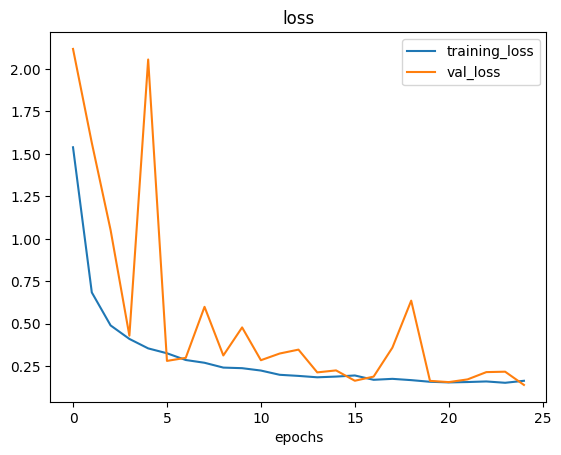

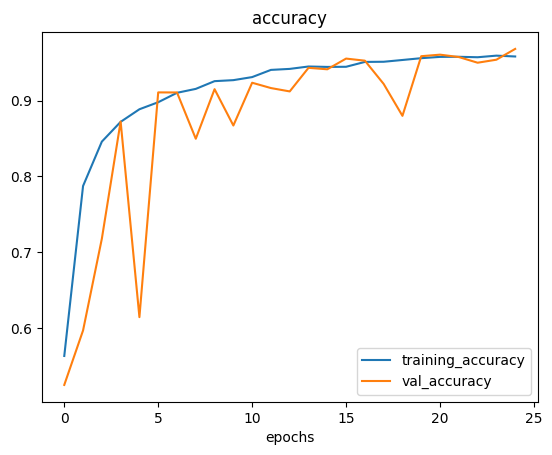

In [19]:
plot_loss_curves(history)

In [20]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2custom_4block_2080/cp-0025.keras')
saved.evaluate(batched_test, verbose=2)

W0000 00:00:1719468249.372961     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 - 90s - 525ms/step - accuracy: 0.9637 - loss: 0.1657


[0.16568411886692047, 0.9637296199798584]

# L 50%

In [29]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.5,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=4,
    classes=38
)
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [30]:
model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_conv         │ (None, 64, 64, 8) │         72 │ input_layer_6[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_conv        │ (None, 64, 64, 8) │        144 │ input_layer_7[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_bn           │ (None, 64, 64, 8) │         32 │ l_stem_conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_bn          │ (None, 64, 64, 8) │         32 │ ab_stem_conv[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_activation   │ (None, 64, 64, 8) │          0 │ l_stem_bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_activation  │ (None, 64, 64, 8) │          0 │ ab_stem_bn[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 4) │        288 │ l_stem_activatio… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 4) │        288 │ ab_stem_activati… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 4) │         16 │ l_block1a_projec… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 4) │         16 │ ab_block1a_proje… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 4) │          0 │ l_block1a_projec… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 4) │          0 │ ab_block1a_proje… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block2a_expand_c… │ (None, 32, 32,    │        576 │ l_block1a_projec… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block2a_expand_… │ (None, 32, 32,    │        576 │ ab_block1a_proje… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block2a_expand_bn │ (None, 32, 32,    │         64 │ l_block2a_expand

 Total params: 792,142 (3.02 MB)

 Trainable params: 775,998 (2.96 MB)

 Non-trainable params: 16,144 (63.06 KB)

In [31]:
checkpoint_path = "/kaggle/working/two_branch_efficientnetv2custom_4block_5050/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
      5/Unknown 59s 33ms/step - accuracy: 0.0444 - loss: 4.5015  

W0000 00:00:1719468991.212691     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   1188/Unknown 112s 45ms/step - accuracy: 0.4463 - loss: 2.0925

W0000 00:00:1719469048.771628     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.43764, saving model to /kaggle/working/two_branch_efficientnetv2custom_4block_5050/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 121s 53ms/step - accuracy: 0.4465 - loss: 2.0919 - val_accuracy: 0.4376 - val_loss: 2.4138
Epoch 2/25
1186/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7682 - loss: 0.7473
Epoch 2: val_accuracy improved from 0.43764 to 0.82210, saving model to /kaggle/working/two_branch_efficientnetv2custom_4block_5050/cp-0002.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.7682 - loss: 0.7471 - val_accuracy: 0.8221 - val_loss: 0.5914
Epoch 3/25
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8327 - loss: 0.5332
Epoch 3: val_accuracy improved from 0.82210 to 0.84588, saving model to /kaggle/working/two_branch_efficientnetv2custom_4block_5050/cp-0003.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.8327 - loss: 0.5331 - val_accuracy: 0.8459 - val_loss: 0.4922
Epoch 4/25
1188/1188 ━

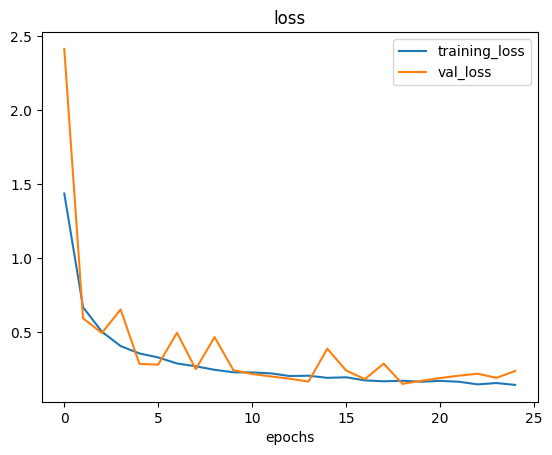

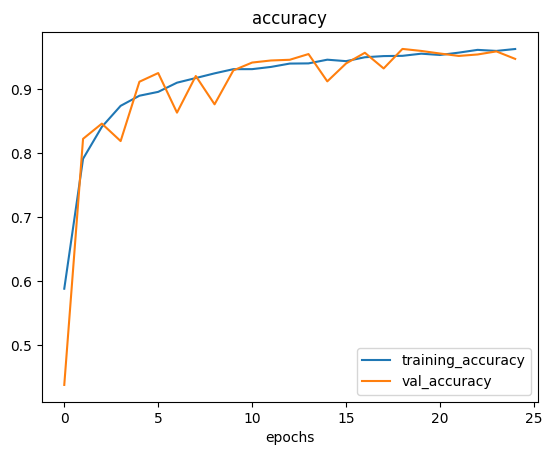

In [32]:
plot_loss_curves(history)

In [33]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2custom_4block_5050/cp-0019.keras')
saved.evaluate(batched_test, verbose=2)

W0000 00:00:1719469829.375512     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 - 66s - 384ms/step - accuracy: 0.9632 - loss: 0.1495


[0.14952604472637177, 0.9631800651550293]

# L 80%

In [34]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.8,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=4,
    classes=38
)
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [35]:
model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_conv         │ (None, 64, 64,    │        108 │ input_layer_8[0]… │
│ (Conv2D)            │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_conv        │ (None, 64, 64, 4) │         72 │ input_layer_9[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_bn           │ (None, 64, 64,    │         48 │ l_stem_conv[0][0] │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_bn          │ (None, 64, 64, 4) │         16 │ ab_stem_conv[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_activation   │ (None, 64, 64,    │          0 │ l_stem_bn[0][0]   │
│ (Activation)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_activation  │ (None, 64, 64, 4) │          0 │ ab_stem_bn[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 6) │        648 │ l_stem_activatio… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 2) │         72 │ ab_stem_activati… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 6) │         24 │ l_block1a_projec… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 2) │          8 │ ab_block1a_proje… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 6) │          0 │ l_block1a_projec… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 2) │          0 │ ab_block1a_proje… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block2a_expand_c… │ (None, 32, 32,    │      1,296 │ l_block1a_projec… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block2a_expand_… │ (None, 32, 32, 8) │        144 │ ab_block1a_proje… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block2a_expand_bn │ (None, 32, 32,    │         96 │ l_block2a_expand

 Total params: 795,225 (3.03 MB)

 Trainable params: 779,081 (2.97 MB)

 Non-trainable params: 16,144 (63.06 KB)

In [36]:
checkpoint_path = "/kaggle/working/two_branch_efficientnetv2custom_4block_8020/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
      5/Unknown 68s 30ms/step - accuracy: 0.0617 - loss: 4.3824

W0000 00:00:1719470020.235617     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   1188/Unknown 131s 53ms/step - accuracy: 0.3848 - loss: 2.3102

W0000 00:00:1719470087.643788     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.77768, saving model to /kaggle/working/two_branch_efficientnetv2custom_4block_8020/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 143s 63ms/step - accuracy: 0.3849 - loss: 2.3096 - val_accuracy: 0.7777 - val_loss: 0.7158
Epoch 2/25
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7701 - loss: 0.7305
Epoch 2: val_accuracy did not improve from 0.77768
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.7702 - loss: 0.7304 - val_accuracy: 0.6273 - val_loss: 1.4509
Epoch 3/25
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8416 - loss: 0.4977
Epoch 3: val_accuracy improved from 0.77768 to 0.78837, saving model to /kaggle/working/two_branch_efficientnetv2custom_4block_8020/cp-0003.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.8416 - loss: 0.4977 - val_accuracy: 0.7884 - val_loss: 0.6928
Epoch 4/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8704 - loss: 0.4084
Epoch 4: val_accuracy improv

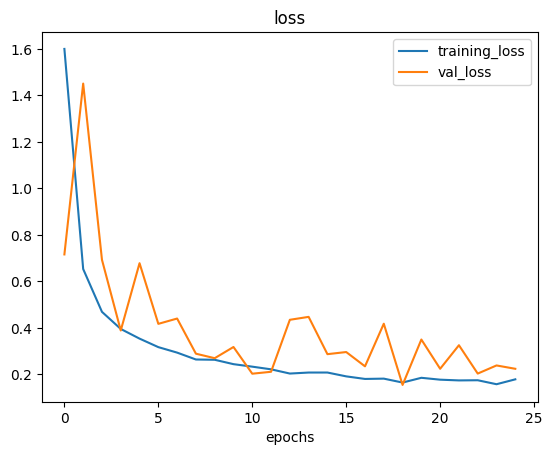

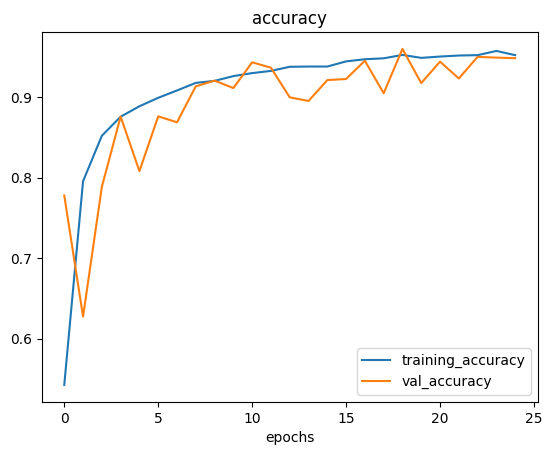

In [37]:
plot_loss_curves(history)

In [38]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2custom_4block_8020/cp-0019.keras')
saved.evaluate(batched_test, verbose=2)

W0000 00:00:1719470885.772248     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 - 60s - 354ms/step - accuracy: 0.9555 - loss: 0.1606


[0.16058361530303955, 0.9554863572120667]